In [155]:
%gui qt
%matplotlib notebook

import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
#import scipy.interpolate as spi
import pickle

import numpy as np
from numpy import linalg as LA

from filters import butter_lowpass_lfilter, butter_highpass_lfilter
from pykalman import KalmanFilter
import peakdet
import KF

fs = 25

## Open saved data (pickle)

In [159]:

import cpd
#If you want to open a file from another folder, create a new cell, type "cd" then "cd/FOLDER/FOLDER" to change the 
#working directory to the folder that contains your file.

filename = '31_160722_1rpm-raw.p'
raw_pd = pd.read_pickle(filename)

raw_mat = raw_pd.as_matrix()
rot_dir=raw_mat.T[:9][0]
raw_mat = raw_mat.T[:9]
raw_mat = raw_mat.T
raw_mat = raw_mat.astype(np.float)

rot_speed = input('Enter rotataional speed of stim (rpm): ')
rot_speed *= 6

Enter rotataional speed of stim (rpm): 1


In [111]:
new_mat = np.zeros((len(raw_mat),9))
for i in range(8):
    new_mat[:,i]=raw_mat[:,i+1]
new_mat[:,8]=raw_mat[:,0]

# Create vectors from points

In [160]:
vectors = []
vector_mag = []
slopes = []
midpt = []

vectors = (raw_mat[:,4]-raw_mat[:,0],raw_mat[:,5]-raw_mat[:,1]) #if errors, add 1 to all column values
vector_mag = np.sqrt(vectors[0]**2 + vectors[1]**2)
slopes = vectors[1]/vectors[0]

for i in range(len(vectors[0])):
    #midpt.append(([red_mat[i,0]+vectors[0][i]/2,red_mat[i,1]+vectors[1][i]/2]))
    midpt.append(([raw_mat[i,0]+vectors[0][i]/2,raw_mat[i,1]+vectors[1][i]/2]))

mid_KF = KF.KFilt(np.array(midpt)) 
#mid_KF = np.column_stack((mid_KF[0][:,0],mid_KF[1][:,0],mid_KF[0][:,1],mid_KF[1][:,1],frames))
mid_mag = np.sqrt(mid_KF[0][:,0]**2 + mid_KF[0][:,1]**2)

<IPython.core.display.Javascript object>


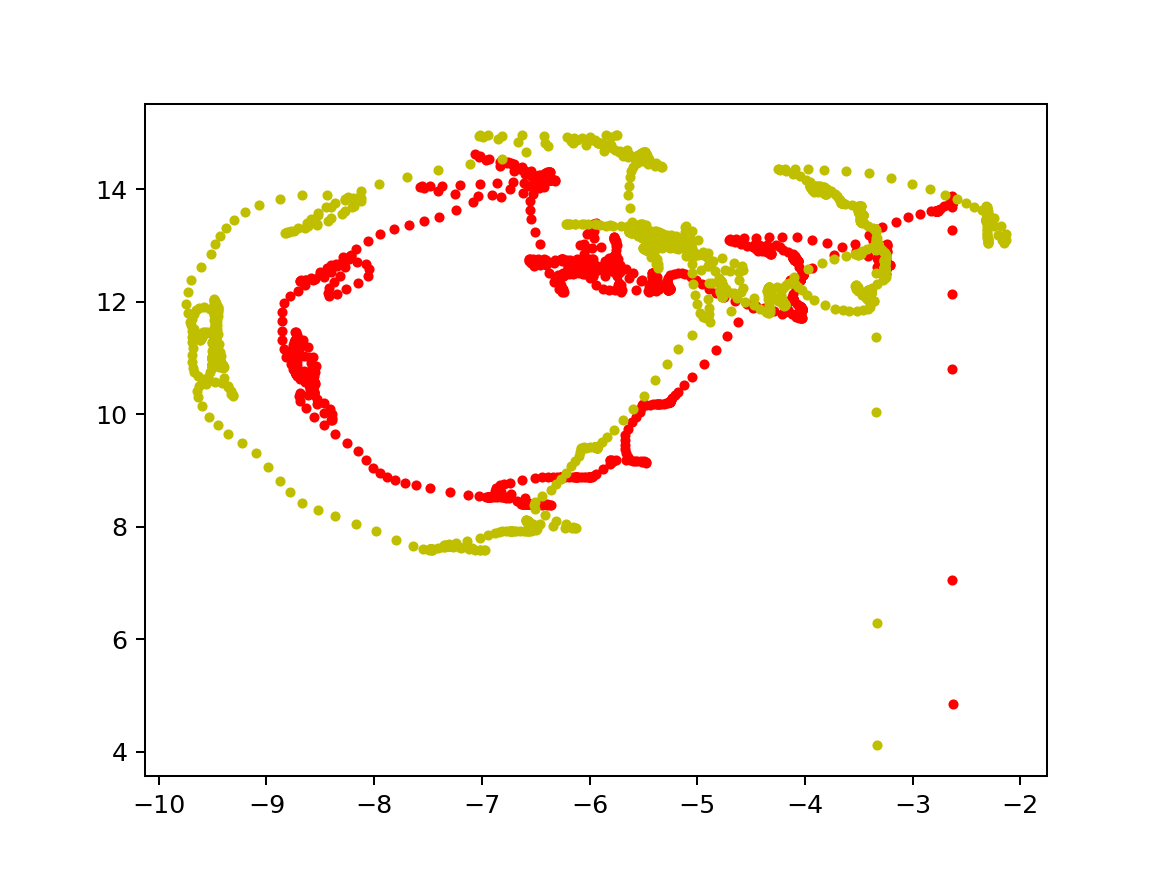

In [161]:
plt.figure()
plt.plot(raw_mat[:,0],raw_mat[:,1],'r.',raw_mat[:,4],raw_mat[:,5],'y.')
plt.show()

# Head angle and angular velocity

In [162]:
fs = 25
frames = raw_mat[:,8] #if errors, try [:,0]
T = frames/25.

#get angle from horizontal, in degrees
global theta
theta = np.unwrap(np.arctan2(vectors[1],vectors[0]))
theta_deg = theta*180/(2*np.pi)

#smooth angular velocity
w = np.diff(theta_deg)*fs

#lowpass filter to smooth (2/3: not necessary to smooth)
w_smooth = butter_lowpass_lfilter(w,1.5,fs=25)

<IPython.core.display.Javascript object>


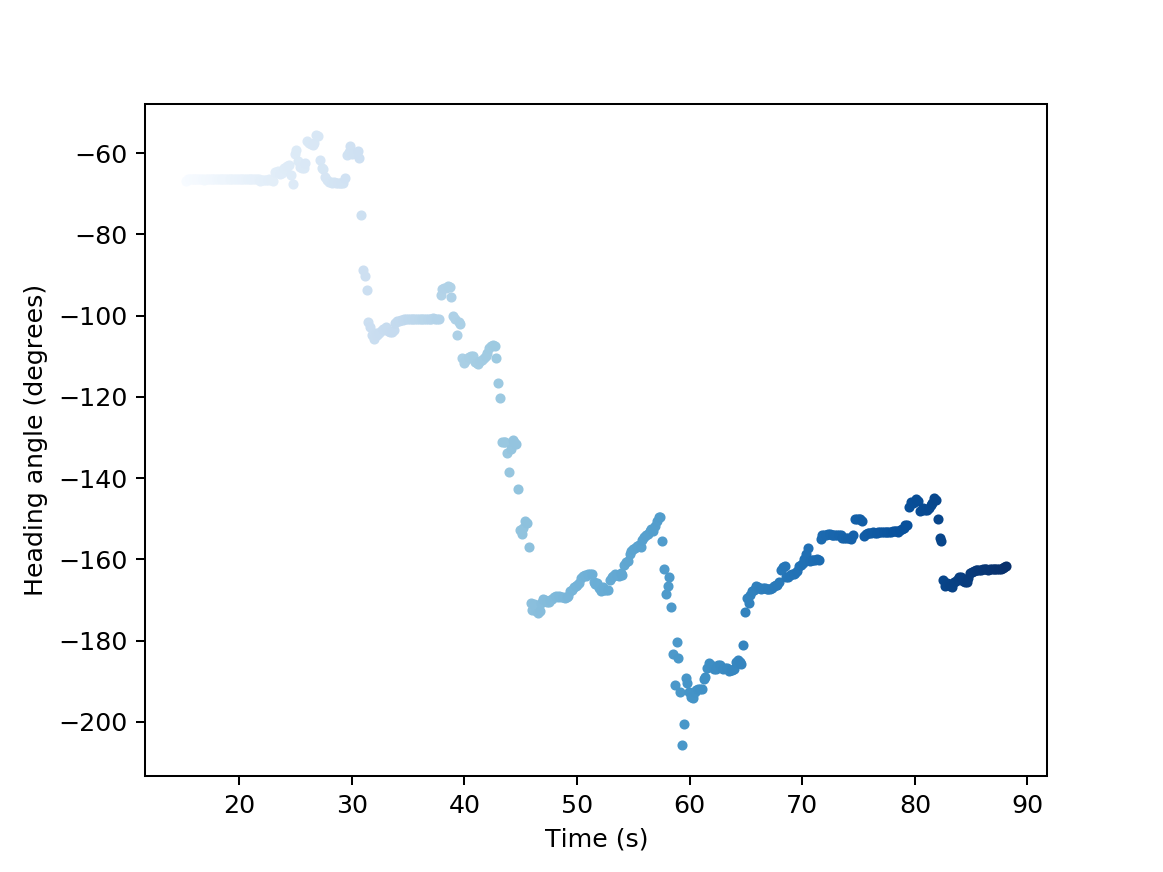

In [163]:
plt.figure()
for i in range(0,len(theta),4):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(T[i],theta_deg[i],'.',color=colorVal)#plt.plot(T[1:],w_smooth,'k')
#for i in range(0,len(w),4):
#    colorVal = scalarMap.to_rgba(i)
#    plt.plot(T[i],w_smooth[i],'.',color=colorVal)
plt.ylabel('Heading angle (degrees)')
plt.xlabel('Time (s)')
plt.show()

<IPython.core.display.Javascript object>


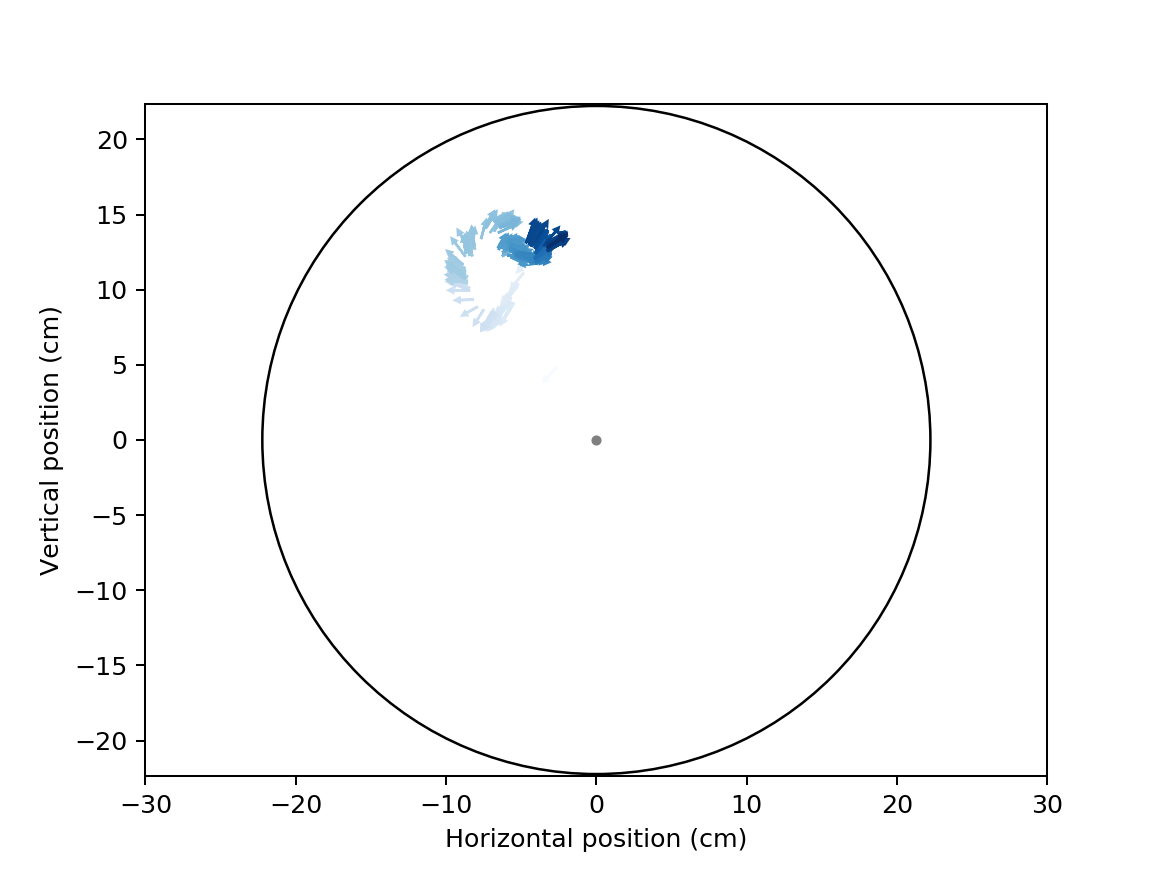

In [164]:
#plot vectors
#cmap = plt.cm.autumn
cmap = plt.cm.Blues
cNorm  = colors.Normalize(vmin=0, vmax=len(vectors[0]))#np.min(DATA[:,4]), vmax=np.max(DATA[:,4]))
#cNorm  = colors.Normalize(vmin=np.min(u_theta), vmax=np.max(u_theta))
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)
a = [i[0] for i in sorted(enumerate(theta_deg), key=lambda x:x[1])]

plt.figure()
ax = plt.axes()

for i in range(0,len(vectors[0]),4):
	colorVal = scalarMap.to_rgba(i)#a[i]
	ax.arrow(raw_mat[i,0],raw_mat[i,1],vectors[0][i],vectors[1][i], color=colorVal,head_length=0.3, head_width=0.3)

circ1 = plt.Circle((0,0),44.45/2,color='k',fill=False)
ax.add_artist(circ1)
plt.plot(0,0,'.',color='gray')
plt.axis('equal')
plt.xlim((-30,30))
plt.ylim((-30,30))
plt.xlabel('Horizontal position (cm)')
plt.ylabel('Vertical position (cm)')
plt.show()

# Nystagmus detection

(26.079999999999998, 15)
(27.039999999999999, 56)
(29.640000000000001, 31)
(31.239999999999998, 161)
31.24
(38.039999999999999, 22)
(39.280000000000001, -2)
(39.560000000000002, 41)
(41.560000000000002, 31)
(43.159999999999997, 3)
(43.640000000000001, 7)
(44.280000000000001, 20)
(45.439999999999998, 12)
(46.280000000000001, 8)
(46.960000000000001, 141)
(52.960000000000001, 122)
(58.200000000000003, 4)
(58.719999999999999, -4)
(58.920000000000002, 11)
(59.719999999999999, 31)
(61.32, 83)
(65.0, 5)
(65.560000000000002, 56)
(68.159999999999997, 53)
(70.640000000000001, 19)
(71.760000000000005, 65)
(74.719999999999999, 114)
(79.640000000000001, 46)
(81.840000000000003, 5)


<IPython.core.display.Javascript object>


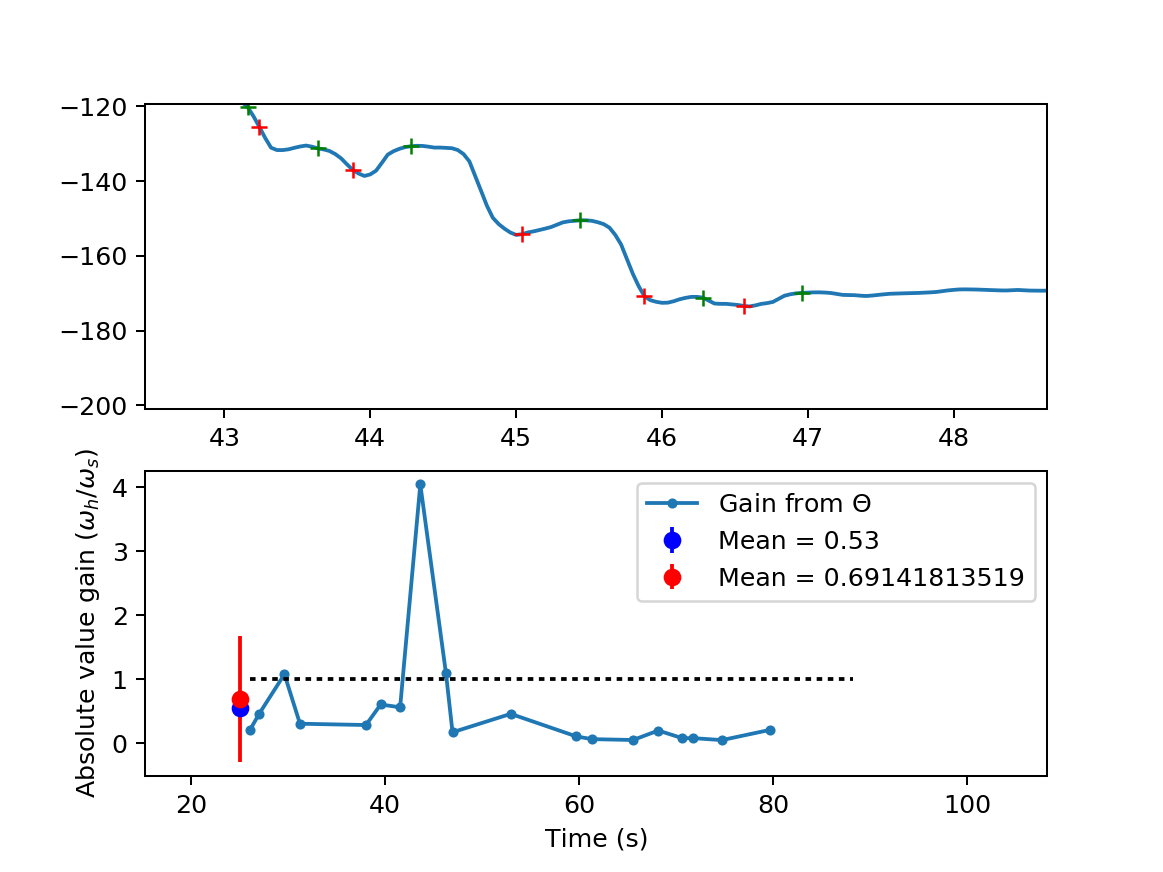

In [165]:
#Find peaks, min and max
dp = 30 # distance between peaks
if rot_speed > dp:
    dp = rot_speed-10
peaks = peakdet.peakdet(w,dp)

maxes = peaks[0].T[0].astype(int)
mins = peaks[1].T[0].astype(int)

#locations = mins
#TODO: fix this!
CW = np.where(T[maxes]<350)
CCW = np.where(T[maxes]>350)
#locations = input('Use min or max peaks? ')
#if locations.lower =='min':
#    locations = mins
#elif locations.lower == 'max':
#    locations = maxes
locations = list(maxes[CW])#+list(maxes[CCW])
#locations

#TODO: change with rotation direction
#maxes == CCW
#mins == CW

slopes = []
gains = []
angvel = []
nyst_time=[]
nyst_bool = np.zeros(np.size(theta_deg),dtype=bool)

for i in range(2,len(locations)):
    if i > 2:
        start = int(locations[i-1])+5
        end = int(locations[i])-4
        length = end-start
        print(T[start],length)
        if start>=end or length<6:
            continue
        elif length > 150:
            print(T[start])
            end = start+60#int(maxes[i-1])+300
        linfit = scipy.stats.linregress(T[start:end],theta_deg[start:end]) 
        slopes.append(linfit.slope)
        if np.abs(linfit.slope/rot_speed) < 5:
            nyst_bool[start:end]=True
            angvel.append(np.mean(w[start:end]))
            gains.append(linfit.slope/rot_speed)
            nyst_time.append(T[int(start)])
            
mean_gain = np.nanmean(np.abs(gains))
mean_ang_gain = np.nanmean(np.abs(angvel))/rot_speed
if not np.all(nyst_bool==False):
    a = np.linspace(nyst_time[0],T[-1])

    plt.figure()
    plt.subplot(211)
    #plt.plot(subset_T,subset)
    plt.plot(T,theta_deg)
    for i in range(len(locations)):
        if i > 2:
            plt.plot(T[int(locations[i-1])+5],theta_deg[int(locations[i-1])+5],'g+') #start of fit region
            plt.plot(T[int(locations[i])-5],theta_deg[int(locations[i]-5)],'r+') #end of fit region, T[int(locations[i])-4]
    plt.xlim((T[0],T[-1]+20))
    
    plt.subplot(212)
    plt.plot(nyst_time,np.abs(gains),'.-', label='Gain from $\Theta$')
    #plt.plot(np.abs(angvel)/6,'.-',label='Gain from $\omega$')
    plt.errorbar(a[0]-1,np.mean(np.abs(gains[:-1])),\
                 yerr=np.std(np.abs(gains[:-1]))/len(gains[:-1]),\
                 fmt='bo',label='Mean = {:.3}'.format(mean_gain))
    plt.errorbar(a[0]-1,np.mean(np.abs(angvel)/6),\
                 yerr=np.std(np.abs(angvel)/6),\
                 fmt='ro',label='Mean = {}'.format(mean_ang_gain))

    plt.plot(a,np.ones(np.size(a)),'k:')
    plt.xlim((T[0],T[-1]+20))
    plt.ylabel("Absolute value gain ($\omega_h/ \omega_s$)")
    plt.xlabel('Time (s)')

    #plt.title('Calculating gain between nystagmus events')
    plt.legend()
    plt.show()
else:
    print("No nystagmus events found")


<IPython.core.display.Javascript object>


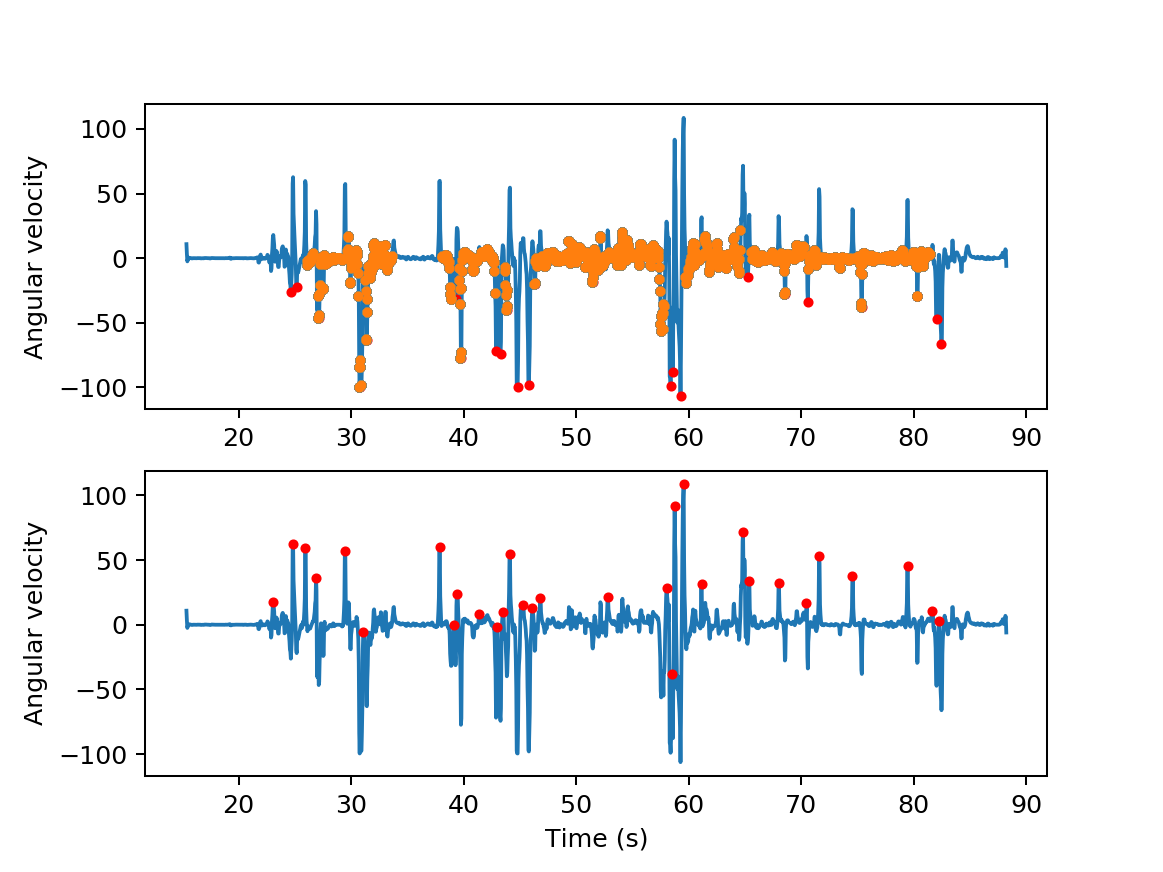

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1823 but corresponding boolean dimension is 1824


In [150]:
plt.figure()
plt.subplot(211)
plt.plot(T[1:],w)
for i in range(len(mins)):
    plt.plot(T[mins[i]+1],w[mins[i]],'r.')
    plt.plot(T[nyst_bool],w[nyst_bool],'.')
plt.ylabel('Angular velocity')

plt.subplot(212)
plt.plot(T[1:],w)
for i in range(len(maxes)):
    plt.plot(T[maxes[i]+1],w[maxes[i]],'r.')
plt.ylabel('Angular velocity')
plt.xlabel('Time (s)')
plt.show()

# CPD (slow)

In [157]:
grating = input('Enter grating size (in): ') #1./20
grating = [grating *2.54]    #get grating distance in cm
global grating
per = 2*grating    #calculate period
diam = 44.45  #diameter in cm

x,y = cpd.make_circ(diam/2)
circle = cpd.Polygon(zip(x,y))
dt = np.linspace(0.01,44.45,800)

#cpd,view_dist = cpd.calc_view_dist(yellow_mat[:,:2],vector_mag)
spDens,view_dist = cpd.calc_view_dist(raw_mat[:,4:6],vector_mag,circle,theta,grating,dt)


Enter grating size (in): 0.05


# Headwag detection

<IPython.core.display.Javascript object>


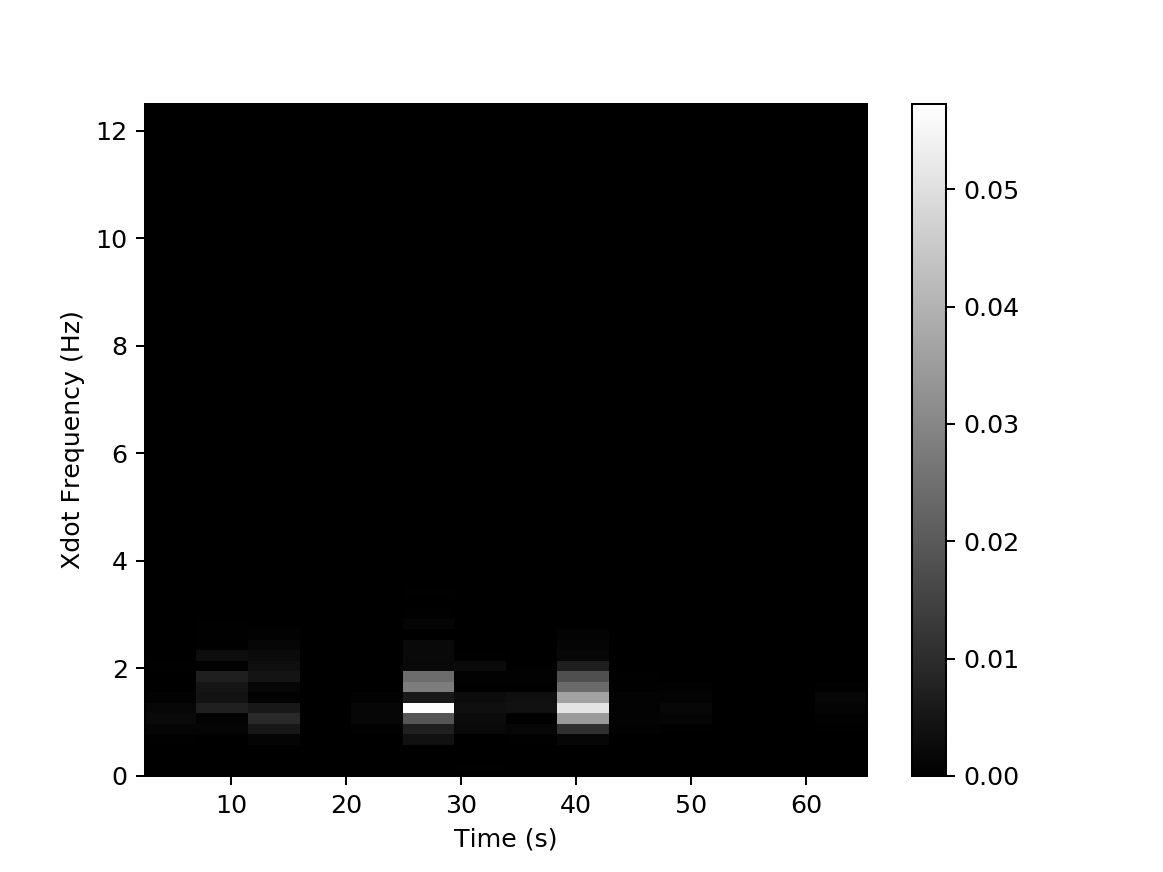

In [166]:
N = len(raw_mat) #number samples

HPF_mid = butter_highpass_lfilter(mid_mag,1,25)

#make window
Nx = 128 #TODO: NFFT of sample length
win = scipy.signal.get_window('hann',Nx=Nx)
#print(np.sqrt(len(HPF_mid[100:])), np.sqrt(128))

#start 50 timesteps out to get rid of onset ringing
f_x, t_x, S_x = scipy.signal.spectrogram(HPF_mid[100:],fs,window=win,nperseg=Nx)#red_mat[:,2],fs) #x velocity

#plotting
plt.figure()
plt.pcolormesh(t_x, f_x, S_x, cmap='gray')
plt.colorbar()
#plt.ylim((0,6))
plt.ylabel('Xdot Frequency (Hz)')
plt.xlabel('Time (s)')

thresh = next(x[0] for x in enumerate(f_x) if x[1] > 0)
s_dt = np.diff(t_x)[0]   #timestep of spectrogram
dt_frames = np.int(np.round(s_dt*25))
dt = np.diff(t_x)[0]*25

#frame number where headwagging occurs
head_wag = []
head_wag_idx = []
for i in range(S_x.shape[1]-1):
    if max(S_x[thresh:,i])>=0.0001:
        head_wag.append(np.round((t_x.T[i]+T[0]+s_dt*1.5)))

#get indices where head wagging is detected
for i in range(len(head_wag)):
    head_wag_idx.append(np.where(np.round(T,2)==head_wag[i])[0][0])  #+T[0] deals with time offset between realtime and spectrogram time

hw_events = []
hw_cpd = []
hw_vd = []
head_wag_idx=[]
hw_bool = np.zeros(np.size(raw_mat[:,0]), dtype=bool)

#TODO: get rid of hw_events. ultimately only have hw_bool, 
#TODO: make separate cell for hw_cpd, hw_vd
#for i in range(len(head_wag_idx)-1):
for row in head_wag_idx:
    if row+dt_frames<len(raw_mat[:,0]):
        hw_events.append(raw_mat[row:row+dt_frames,0])
        hw_bool[row:row+dt_frames]=True
    else:
        hw_events.append(raw_mat[row:,0])
        hw_bool[row:]=True
   
    hw_cpd.append(cpd[row:row+dt_frames])
    hw_vd.append(view_dist[row:row+dt_frames])

#mean_stats = get_hw_stats(hw_events,hw_cpd)
#hw_data = pd.DataFrame({'head_wag':hw_events,'cpd':hw_cpd,'vd':hw_vd})


<IPython.core.display.Javascript object>


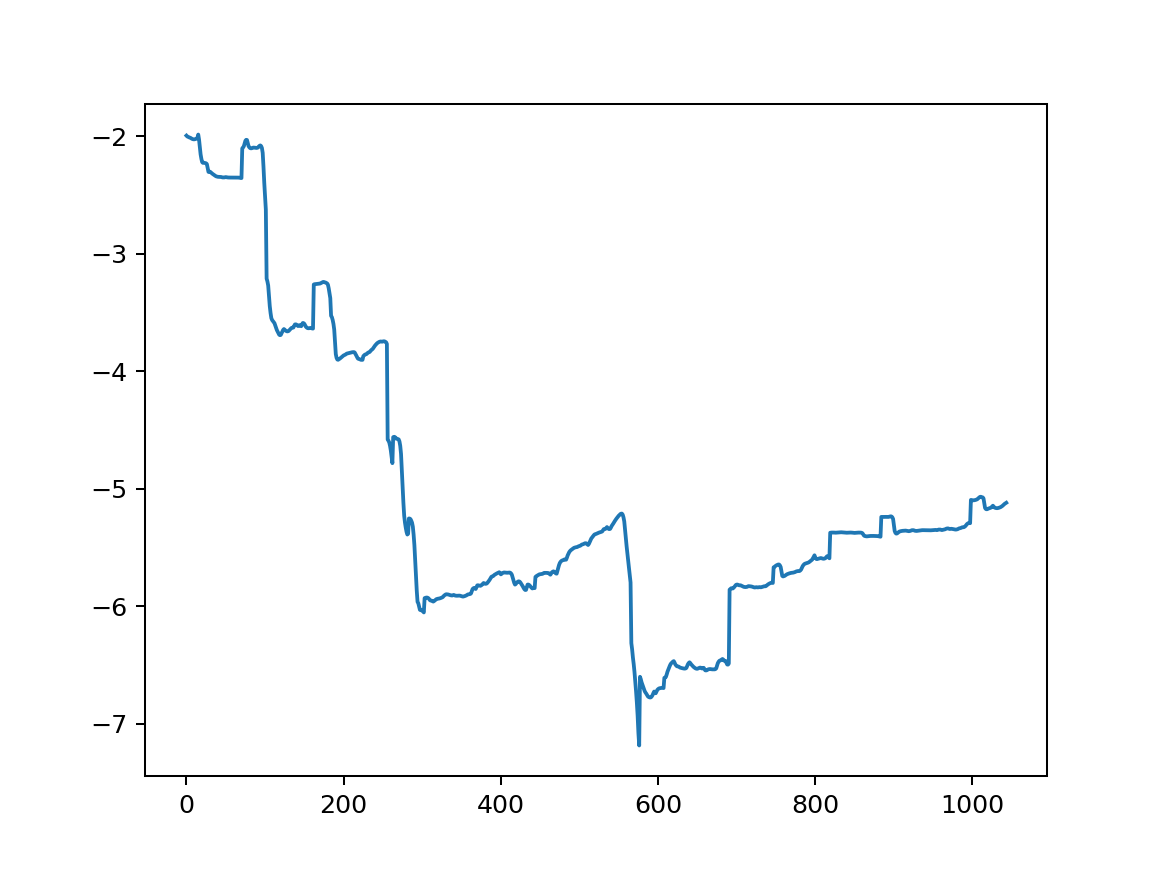

False

In [148]:
plt.figure()
plt.plot(theta[nyst_bool])#HPF_mid[100:])
plt.show()
np.any(hw_bool==True)

# Save data (pickle)

In [176]:
processed_data = np.column_stack((frames,raw_mat[:,:8],vectors[0],vectors[1],\
                                  vector_mag,theta,view_dist,spDens,nyst_bool,hw_bool))

processed_pd = pd.DataFrame(processed_data,
                      columns = ['frames','red_x','red_y','red x vel','red y vel','yellow_x',\
                                 'yellow_y','yellow x vel','yellow y vel','vector_dx','vector_dy',\
                                'vector_mag','theta','view dist','cpd','nyst_bool','hw_bool'])
savename = filename[:len(filename)-5]+'processed.p'
print('Savename will be {}'.format(savename))
#nameOK = input('Continue with savename? (Y/n) ')

#if np.strmatch('n'):
#    savename = input('Enter savename, complete with extentsion: ')

processed_pd.to_pickle(savename)
print('Data saved to {}'.format(savename))
#processed_pd.to_pickle('94_0.5rpm1_processed.p')

Savename will be 31_160722_1rpm-processed.p
Data saved to 31_160722_1rpm-processed.p


In [139]:
processed_pd

,frames,red_x,red_y,red x vel,red y vel,yellow_x,yellow_y,yellow x vel,yellow y vel,vector_dx,vector_dy,vector_mag,theta,view dist,cpd,nyst_bool,hw_bool
0,383.0,-2.627612,4.841364,-0.002279,-8.124184e-01,-3.330134,4.110616,-0.003865,-8.142053e-01,-0.702522,-0.730748,1.013671,-2.336504,29.839232,4.10076,0.0,0.0
1,384.0,-2.630722,7.049016,-0.002062,9.365479e-01,-3.335306,6.293555,-0.003530,9.491423e-01,-0.704584,-0.755462,1.033035,-2.321362,31.047257,4.26677,0.0,0.0
2,385.0,-2.633554,10.807266,-0.001356,1.090762e+00,-3.340048,10.043028,-0.002414,1.099042e+00,-0.706494,-0.764238,1.040765,-2.316953,32.791806,4.50652,0.0,0.0
3,386.0,-2.634455,12.135847,-0.000781,9.173657e-01,-3.341858,11.375861,-0.001450,9.220914e-01,-0.707402,-0.759986,1.038266,-2.320375,33.302790,4.57674,0.0,0.0
4,387.0,-2.634809,13.272671,-0.000423,5.963669e-01,-3.342738,12.513676,-0.000768,5.970358e-01,-0.707929,-0.758995,1.037900,-2.321397,33.692827,4.63034,0.0,0.0
5,388.0,-2.635039,13.675264,-0.000173,3.375148e-01,-3.343048,12.917541,-0.000325,3.360682e-01,-0.708009,-0.757723,1.037025,-2.322290,33.806857,4.64601,0.0,0.0
6,389.0,-2.635031,13.830441,-0.000016,1.706063e-01,-3.342945,13.071852,-0.000117,1.686685e-01,-0.707914,-0.758590,1.037594,-2.321653,33.859009,4.65318,0.0,0.0
7,390.0,-2.634905,13.885634,0.000065,6.616733e-02,-3.342906,13.126425,-0.000009,6.429747e-02,-0.708002,-0.759209,1.038106,-2.321307,33.912463,4.66053,0.0,0.0
8,391.0,-2.634707,13.843638,0.000071,2.001097e-02,-3.342770,13.083798,0.000016,1.871223e-02,-0.708063,-0.759840,1.038609,-2.320936,33.910720,4.66029,0.0,0.0
9,392.0,-2.634639,13.828878,0.000068,-2.996756e-03,-3.342723,13.068575,0.000014,-3.821660e-03,-0.708084,-0.760303,1.038962,-2.320647,33.909453,4.66011,0.0,0.0
